# Práctica 2: Detección basada en ligandos: similitud de compuestos y agrupamiento de compuestos

> **Note:** Este libro esta disponible de dos maneras: 
> 1. Descargando el repositorio y siguiendo las instrucciones que estan en el archivo [README.md](https://github.com/ramirezlab/PILE/blob/main/README.md)
> 2. Haciendo clic aquí en [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ramirezlab/PILE/blob/main/2.%20De%20datos%20a%20gráficas%3A%20Propiedades%20drug-likeness%20y%20similitud%20química%20con%20python/2.4_Practica-2.es.ipynb?hl=es)

## Teoría

### **Huellas dactilares moleculares**
Las huellas dactilares moleculares son herramientas quimioinformáticas esenciales para el cribado virtual y el mapeo del espacio químico. Esta es una forma de describir una estructura molecular que puede convertir una estructura molecular en una cadena de bits<sup> **1** </sup>. Cada bit corresponde a una característica o entorno molecular predefinido, donde "1" representa la presencia y "0" la ausencia de una característica. Dado que la huella digital molecular codifica la estructura de una molécula, es un método útil para describir la similitud estructural entre las moléculas como un descriptor molecular.

#### **Huellas dactilares de Morgan**
La huella digital molecular más popular es la huella dactilar de Morgan que se basa en el algoritmo de Morgan. Estos bits generados por algoritmos corresponden a los entornos circulares de cada átomo en una molécula y el número de enlaces y átomos vecinos a considerar está establecido por el radio, que son predictivos de las actividades biológicas de las moléculas orgánicas pequeñas<sup> **2** </sup>.

### **Medida de similitud molecular: coeficiente de Tanimoto**
Dos de estas huellas dactilares se comparan más comúnmente con la métrica de similitud de Tanimoto. Estas métricas toman un valor entre 0 y 1, correspondiendo 1 a huellas dactilares idénticas<sup> **3** </sup>.


<img src="img/Coeficiente de tanimoto-es.jpg" alt="Tanimoto-coefficient" width="800"/>

### **Agrupación**
Es la tarea de agrupar un conjunto de objetos de tal manera que los objetos del mismo grupo (llamado clúster) sean más similares entre sí que a los de otros grupos (clusters). La agrupación de compuestos en la investigación farmacéutica a menudo se basa en la similitud química o estructural entre compuestos para encontrar grupos que comparten propiedades.

Hay [pasos clave](https://www.sciencedirect.com/science/article/pii/B008045044X001474) en el enfoque de agrupación que seguiremos:

**1. Preparación de datos y codificación compuesta:**

- Los compuestos en los datos de entrada se codificarán como huellas dactilares moleculares.
    
**2. Matriz de similitud (o distancia) de Tanimoto:**

- La similitud entre dos huellas dactilares se calcula mediante el coeficiente de Tanimoto.
- Matriz con similitudes de Tanimoto entre todos los posibles pares de moléculas/huellas dactilares (matriz de similitud n * n con = número de moléculas, solo se usa la matriz del triángulo superior).
- Igualmente, se puede calcular la matriz de distancias (1 - semejanza).
    
**3. Agrupación de moléculas**

- El resultado de la agrupación depende del umbral elegido por el usuario:
    - Cuanto menor sea el valor de corte de la distancia, más similares se requieren los compuestos para pertenecer a un grupo.
    - Cuanto mayor sea el umbral (corte de distancia), más moléculas se considerarán similares, tendrá menos grupos.
    - Cuanto más bajo es el umbral, más pequeños grupos y "singletons" aparecen.

## Planteamiento del problema
Tenemos un conjunto de datos con muchos compuestos y queremos agruparlos porque compuestos similares pueden unirse a los mismos objetivos y mostrar efectos similares. A partir de dicha agrupación, también se puede seleccionar un conjunto diverso de compuestos de un conjunto más grande de compuestos de detección para realizar más pruebas experimentales.

In [35]:
# Importar librerias necesarias para ejecutar este cuaderno
!pip install rdkit
from pathlib import Path
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from rdkit import Chem, DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import (
    PandasTools,
    Draw,
    Descriptors,
    rdFingerprintGenerator,
)

# Ejemplo 1: Comparar una molécula con un conjunto de datos

Inicialmente, queremos comparar una molécula de consulta con todas las moléculas del conjunto de datos que contiene los compuestos bioactivos contra la *glucógeno sintasa quinasa-3 beta*. En este caso la molécula de consulta es **Ruboxistaurin**, queremos buscar moléculas similares.

## Paso 1: Cargar conjunto de datos
El conjunto de datos que contiene los compuestos bioactivos contra la *glucógeno sintasa quinasa-3 beta* lo construimos en el tutorial 2.1_Dataframes.

In [72]:
import pandas as pd

# URL del archivo CSV
csv_url = 'https://raw.githubusercontent.com/ramirezlab/PILE/refs/heads/main/2.%20De%20datos%20a%20gr%C3%A1ficas%3A%20Propiedades%20drug-likeness%20y%20similitud%20qu%C3%ADmica%20con%20python/data/compounds_P49841_full.csv'
# Leer el archivo CSV desde la URL y extraer columnas específicas
columnas_a_usar = ["molecule_chembl_id", "smiles"]
molecule_dataset = pd.read_csv(csv_url, usecols=columnas_a_usar)

# Imprimir el número total de compuestos y mostrar las primeras filas
print(f'# total de compuestos: {len(molecule_dataset)}')
molecule_dataset.head()

# total de compuestos: 2697


,molecule_chembl_id,smiles
0,CHEMBL2386094,O=C1NC(=O)C(c2cn3c4c(cc(F)cc24)CN(C(=O)N2CCOCC...
1,CHEMBL3895998,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCC(N)CC1
2,CHEMBL4084855,COc1ccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](C...
3,CHEMBL564450,COc1cc(C2=C(c3cn(CCN4CCN(C)CC4)c4ccccc34)C(=O)...
4,CHEMBL3957649,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCNCC1


## Paso 2: Generar el fingerprint de la molécula de consulta
Para la molécula Ruboxistaurin, generramos el objeto ROMol a partir de SMILES.

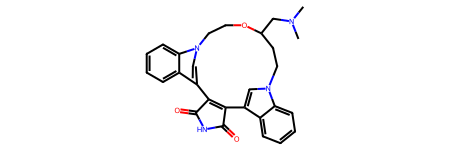

In [73]:
from rdkit import Chem  # Asegúrate de haber importado Chem desde RDKit

# Crear una molécula a partir de una cadena SMILES (Simplified Molecular Input Line Entry System)
# Esta cadena representa la estructura química de la Ruboxistaurina, un inhibidor de la proteína quinasa C
# RDKit interpreta la cadena SMILES y construye internamente un objeto de tipo Mol (molécula)
query = Chem.MolFromSmiles("CN(C)CC1CCN2C=C(C3=CC=CC=C32)C4=C(C5=CN(CCO1)C6=CC=CC=C65)C(=O)NC4=O")

# Mostrar el objeto Mol generado. Este objeto puede ser utilizado en cálculos químicos,
# búsquedas por subestructura, comparación de similitud, visualización, etc.
query

Luego generamos las huella dactilar de Morgan para la molécula de Ruboxistaurin

In [82]:

# Genera el fingerprint circular (ECFP) para la molécula representada por 'query'.
# GetFPs toma una lista de moléculas como entrada.  Aquí, se le pasa una lista
# que contiene solo una molécula ('[query]').  El resultado es una lista de
# fingerprints, incluso si solo se procesa una molécula.
# [0] se utiliza para extraer el primer (y único) fingerprint de la lista resultante.
circular_fp_query = rdFingerprintGenerator.GetFPs([query])[0]

# Convierte el fingerprint circular, que está en un formato de objeto,
# a una cadena de bits (una secuencia de 0s y 1s).
# Esto permite ver el fingerprint como una representación de cadena.
circular_fp_query.ToBitString()

'000000000100000000000000000000000000000000010100000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000001000000000000000000000000000000000000000000000000000000100000000001000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000001010001000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000100000000000000000000000000000000000000000000001000000000000000000000000000000000000000000001000000001000000000000001000000000000000000000000000000000000000000000000

## Paso 3: Calcular las fingerprint del conjunto de datos
Ahora generamos las huellas dactilares de Morgan para todas las moléculas en nuestro conjunto de datos.

In [83]:
# Añade una columna llamada "ROMol" al DataFrame molecule_dataset.
# Esta columna contiene objetos Mol de RDKit generados a partir de las cadenas SMILES
# en la columna "smiles" del DataFrame.
PandasTools.AddMoleculeColumnToFrame(molecule_dataset, "smiles")

# Genera una lista de fingerprints circulares (ECFP) para las moléculas
# en el DataFrame molecule_dataset.
# molecule_dataset["ROMol"] accede a la columna "ROMol" (que contiene objetos Mol de RDKit).
# .tolist() convierte esta columna en una lista de Python de objetos Mol de RDKit, que es
# la entrada esperada para rdFingerprintGenerator.GetFPs().
# El resultado, circular_fp_list, es una lista de objetos fingerprint.
circular_fp_list = rdFingerprintGenerator.GetFPs(molecule_dataset["ROMol"].tolist())


## Paso 4: Calculamos la similitud entre la molécula y el conjunto de datos
Calculamos la similitud de Tanimoto entre la molécula Ruboxistaurin y todas las moléculas de nuestro conjunto de datos utilizando las huellas dactilares de Morgan

In [84]:
# Calcula la similitud de Tanimoto entre la huella digital de la consulta y las huellas digitales de las moléculas en el DataFrame
molecule_dataset["tanimoto_morgan"] = DataStructs.BulkTanimotoSimilarity(circular_fp_query, circular_fp_list)

# Muestra las primeras filas con el identificador ChEMBL de la molécula y su similitud de Tanimoto
molecule_dataset[["molecule_chembl_id", "tanimoto_morgan"]].head()

,molecule_chembl_id,tanimoto_morgan
581,CHEMBL336179,0.603774
1271,CHEMBL340259,0.603774
1099,CHEMBL131035,0.603774
797,CHEMBL130774,0.603774
176,CHEMBL321315,0.593220


Ahora podemos organizar los valores para identificar las moléculas más similares a la Ruboxistaurin

In [85]:
# Ordena el DataFrame molecule_dataset en orden descendente según los valores de la columna "tanimoto_morgan".
# El argumento 'by' especifica la columna para ordenar, 'ascending=False' indica orden descendente,
# e 'inplace=True' modifica el DataFrame original en lugar de devolver uno nuevo.
molecule_dataset.sort_values(by = ["tanimoto_morgan"], ascending=False, inplace=True)
# Devuelve las primeras 5 filas del DataFrame molecule_dataset ordenado.
# Esto permite inspeccionar las moléculas con los valores más altos de "tanimoto_morgan".
molecule_dataset.head(5)



,molecule_chembl_id,smiles,ROMol,tanimoto_morgan
581,CHEMBL336179,O=C1NC(=O)C2=C1c1cn(c3ccccc13)CCOCCOCCOCCOCCn1...,<rdkit.Chem.rdchem.Mol object at 0x15f4e8cf0>,0.603774
797,CHEMBL130774,O=C1NC(=O)C2=C1c1cn(c3ccccc13)CCOCCOCCOCCOCCOC...,<rdkit.Chem.rdchem.Mol object at 0x14b8de430>,0.603774
1271,CHEMBL340259,O=C1NC(=O)C2=C1c1cn(c3ccccc13)CCOCCOCCOCCn1cc2...,<rdkit.Chem.rdchem.Mol object at 0x14b8de3c0>,0.603774
1099,CHEMBL131035,O=C1NC(=O)C2=C1c1cn(c3ccccc13)CCOCCOCCn1cc2c2c...,<rdkit.Chem.rdchem.Mol object at 0x14b8de350>,0.603774
176,CHEMBL321315,CN1CCCn2cc(c3ccccc32)C2=C(C(=O)NC2=O)c2cn(c3cc...,<rdkit.Chem.rdchem.Mol object at 0x14b8de4a0>,0.593220


Finalmente, podemos ver la molécula Ruboxistaurin y las cinco moléculas más parecidas del conjunto de datos

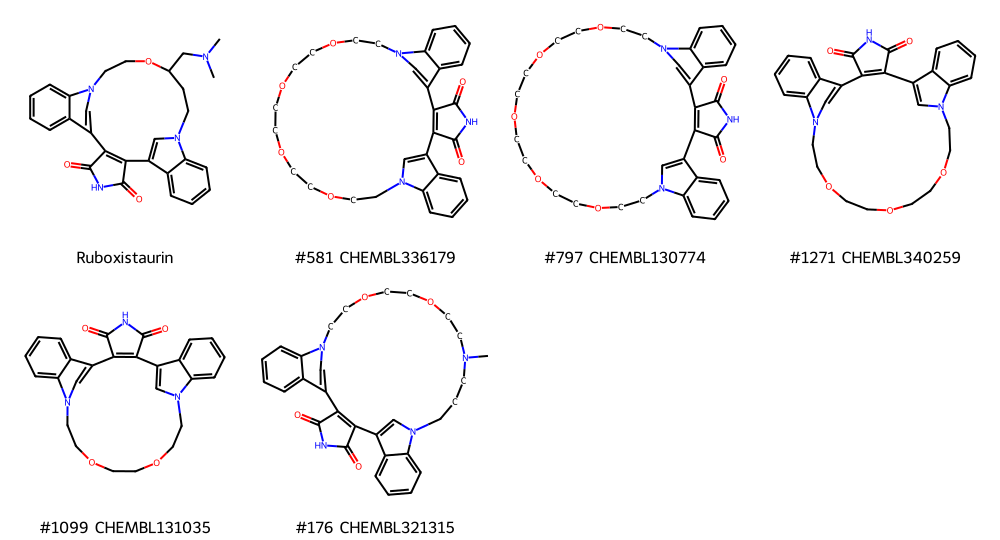

In [87]:
# Establece la variable top_n_molecules en 5, indicando que se seleccionarán las 5 moléculas principales.
top_n_molecules = 5

# Crea un nuevo DataFrame, top_molecules, que contiene las primeras 5 filas de molecule_dataset.
# Esto selecciona las 5 moléculas con los valores más altos de "tanimoto_morgan" (debido a la ordenación anterior).
top_molecules = molecule_dataset[:top_n_molecules]

legends = [
    f"#{index} {molecule['molecule_chembl_id']}"
    for index, molecule in top_molecules.iterrows()
]
# Crea una lista de leyendas para las moléculas que se van a dibujar.
# Itera sobre las filas del DataFrame top_molecules.
# Para cada molécula, formatea una cadena que incluye el índice de la fila y el valor de la columna 'molecule_chembl_id'.
# Esta lista se usará para etiquetar las moléculas en la imagen de la cuadrícula.

Chem.Draw.MolsToGridImage(
    mols=[query] + top_molecules["ROMol"].tolist(),
    # Genera una imagen de cuadrícula que muestra las moléculas.
    # 'mols' es una lista de objetos Mol de RDKit para dibujar.
    #  [query] es la molécula de referencia.
    #  top_molecules["ROMol"].tolist() es la lista de objetos Mol de las 5 moléculas más similares.
    legends=(["Ruboxistaurin"] + legends),
    # 'legends' es una lista de cadenas para etiquetar cada molécula en la cuadrícula.
    #  ["Ruboxistaurin"] es la etiqueta para la molécula de referencia ('query').
    molsPerRow=4,
    # 'molsPerRow' especifica el número de moléculas por fila en la cuadrícula.
    subImgSize=(250, 270),
    # 'subImgSize' especifica el tamaño de cada subimagen (molécula) en la cuadrícula.
)
# Genera la imagen de la cuadrícula usando la función MolsToGridImage de RDKit.

## Distribución de similitud
Para ver gráficamente la distribución de la similitud de Tanimoto, podemos hacer un histograma, recordemos que entre más cerca sea el número a 1, más similares son las moléculas.

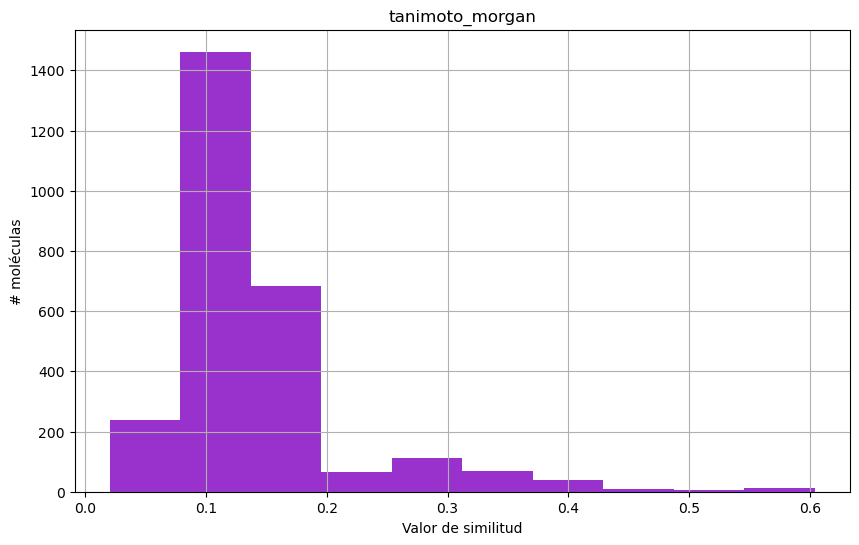

In [88]:
# Configurar la figura de Matplotlib con un tamaño de 10x6
fig, axes = plt.subplots(figsize=(10, 6), nrows=1, ncols=1)

# Generar un histograma de los valores de similitud de Tanimoto en la columna "tanimoto_morgan"
# Puedes ver más nombres de colores en el enlace: https://www.w3schools.com/colors/colors_names.asp
molecule_dataset.hist(["tanimoto_morgan"], ax=axes, color="darkorchid")

# Etiqueta del eje X
axes.set_xlabel("Valor de similitud")

# Etiqueta del eje Y
axes.set_ylabel("# moléculas")

# Mostrar la figura
fig;

También podemos hacer un histograma con una curva de estimaciones de densidad kernel usando seaborn. Con este gráfico, podemos ver la manera como se distribuye el conjunto de datos.

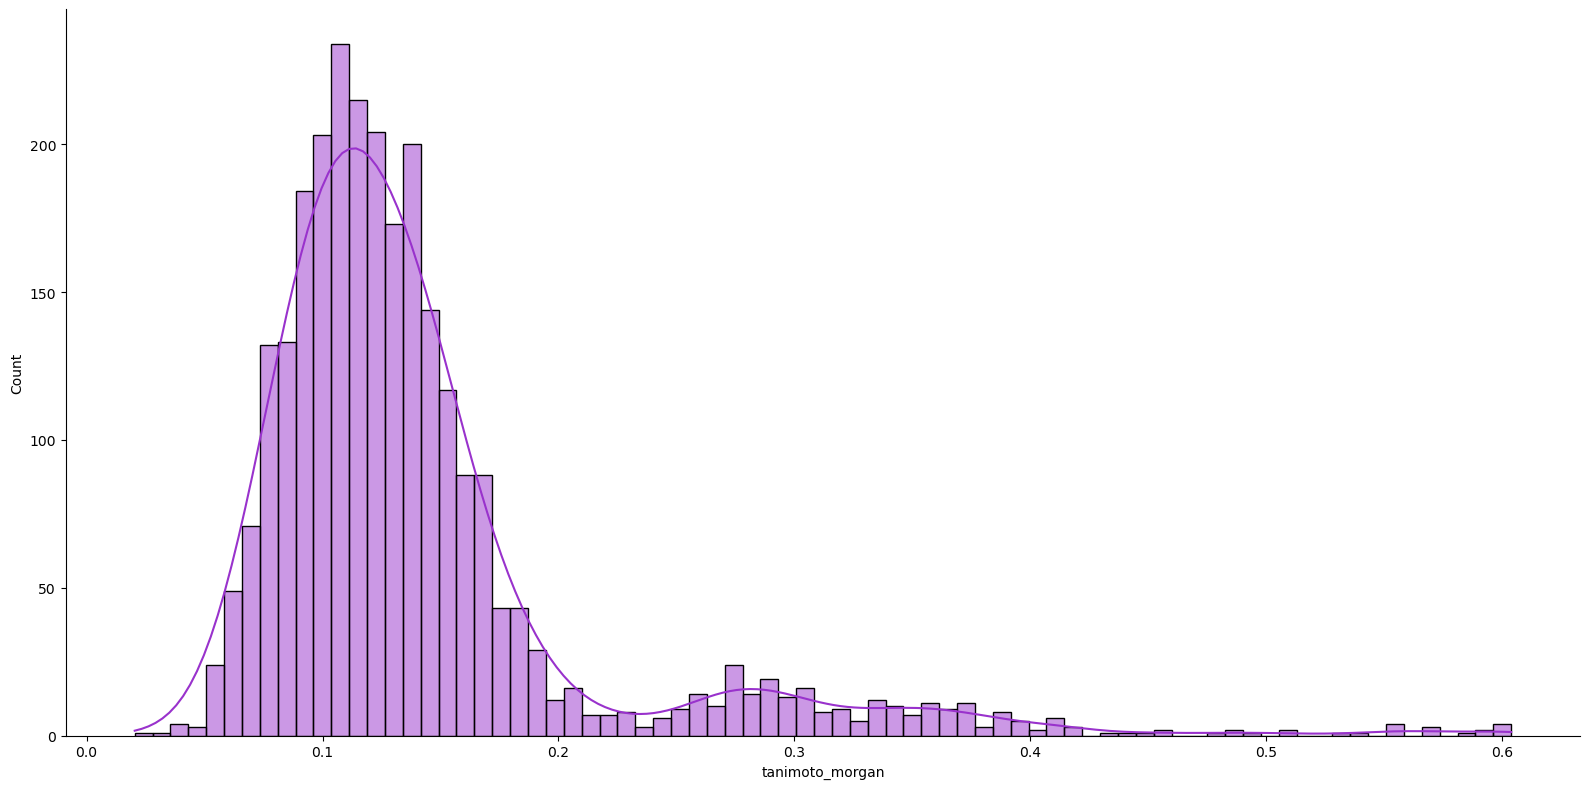

In [89]:
# Generar un gráfico de distribución (displot) con la densidad de kernel (kde) habilitada
# Configurar la altura en 8 y la relación de aspecto en 2 para una visualización más amplia
# Se usa el color "darkorchid" para el gráfico
sns.displot(data=molecule_dataset["tanimoto_morgan"], kde=True, height=8, aspect=2, color="darkorchid")

# Ejemplo 2: Agrupación jerárquica (hierarchical clustering)
El agrupamiento jerárquico (**Hierarchical Clustering** en inglés), es un método comúnmente utilizado para agrupar datos con características similares (los grupos de datos se llaman **clústers**)<sup> **4**</sup>.

El algortimo de agrupamiento jerárquico agrupa los datos basándose en la distancia entre cada uno y buscando que los datos que están dentro de un clúster sean los más similares entre sí. Para nuestro caso, podemos agrupar los compuestos más similares de acuerdo a la distancia de Tanimonoto.

Inicialmente, vamos a utilizar el **agrupamiento tipo Aglomerativo** el cual inicia con cada compuesto como un clúster separado. A cada paso, los dos clústers más cercanos se fusionan creando un nuevo clúster. Estas fusiones se siguen produciendo de manera sucesiva hasta que al final del proceso solo queda un único clúster que aglomera todos los elementos.

Otro aspecto a tener en cuenta es la forma como se mide la **distancia** entre dos clústers, por definición se utiliza la * distancia euclidiana*, pero los algoritmos permiten modificar esta métrica.

## Preparación de datos

Iniciamos cargando el conjunto de datos que contiene los compuestos bioactivos contra la *glucógeno sintasa quinasa-3 beta* lo construimos en el tutorial 2.1_Dataframes.

A partir de los SMILES creamos los objetos *ROMol* y las *fingerprints* de cada compuesto

In [90]:
# Lee un archivo CSV desde una URL de GitHub y lo carga en un DataFrame de Pandas.
# El archivo contiene datos de compuestos, y solo se leen las columnas 'molecule_chembl_id' y 'smiles'.
molecule_dataset = pd.read_csv('https://raw.githubusercontent.com/ramirezlab/PILE/refs/heads/main/2.%20De%20datos%20a%20gr%C3%A1ficas%3A%20Propiedades%20drug-likeness%20y%20similitud%20qu%C3%ADmica%20con%20python/data/compounds_P49841_full.csv', usecols=["molecule_chembl_id", "smiles"])

# Imprime el número total de compuestos (filas) en el DataFrame molecule_dataset.
print(f'# total de compuestos: {len(molecule_dataset)}')

# Añade una columna llamada "ROMol" al DataFrame molecule_dataset.
# Esta columna contiene objetos Mol de RDKit, que son representaciones de las moléculas
# obtenidas a partir de las cadenas SMILES en la columna "smiles".
PandasTools.AddMoleculeColumnToFrame(molecule_dataset, "smiles") # add ROMol

# Genera una lista de fingerprints de Morgan (ECFP) para las moléculas en el DataFrame.
# Primero, se extrae la columna "ROMol" del DataFrame, que contiene los objetos Mol de RDKit.
# .tolist() se utiliza para convertir la columna en una lista de objetos Mol.
# rdFingerprintGenerator.GetFPs() genera los fingerprints para cada molécula en la lista.
morgan_fp_list = rdFingerprintGenerator.GetFPs(molecule_dataset["ROMol"].tolist()) # Morrgan FP

# Añade una nueva columna llamada "morgan_fp" al DataFrame molecule_dataset.
# Esta columna contiene los fingerprints de Morgan generados en el paso anterior.
molecule_dataset['morgan_fp'] = morgan_fp_list

# Imprime las primeras 5 filas del DataFrame molecule_dataset.
# Esto permite ver las columnas y los primeros datos, incluyendo la nueva columna "morgan_fp".
molecule_dataset.head()




# total de compuestos: 2697


,molecule_chembl_id,smiles,ROMol,morgan_fp
0,CHEMBL2386094,O=C1NC(=O)C(c2cn3c4c(cc(F)cc24)CN(C(=O)N2CCOCC...,<rdkit.Chem.rdchem.Mol object at 0x178b78eb0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
1,CHEMBL3895998,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCC(N)CC1,<rdkit.Chem.rdchem.Mol object at 0x178b78f20>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL4084855,COc1ccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](C...,<rdkit.Chem.rdchem.Mol object at 0x178b78f90>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CHEMBL564450,COc1cc(C2=C(c3cn(CCN4CCN(C)CC4)c4ccccc34)C(=O)...,<rdkit.Chem.rdchem.Mol object at 0x14ef8b040>,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
4,CHEMBL3957649,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCNCC1,<rdkit.Chem.rdchem.Mol object at 0x14ef8b0b0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Matriz de la similitud de Tanimoto
Similar a lo trabajado en el ejemplo 1, vamos a encontrar la similitud de cada molécula con el resto de moléculas del conjunto.

Vamos a crear una función cuya entrada es el conjunto de *fingerprints* de los compuestos, y cuya salida es la matriz de similitud de Tanimoto, donde se mide la similitud entre dos compuestos.

In [91]:
def tanimoto_matrix(fp_list):
    # Crear una matriz identidad
    N = len(fp_list)
    similarity_matrix = np.identity(N)
    # índices de las posiciones de la matriz triangular inferior
    a, b = np.tril_indices(N, 0)
    similarities = list()
    for ind, i in enumerate(fp_list):
        # Compare el fingerprint actual con todos los anteriores en la lista
        similarities = np.append(similarities, DataStructs.BulkTanimotoSimilarity(i, fp_list[:ind+1]))
        # Armar la matriz de distancia
    similarity_matrix[a,b] = similarities
    similarity_matrix[b,a] = similarity_matrix[a,b]
    return similarity_matrix

### Agrupamiento de diez moléculas
Para entender el proceso de agrupamiento vamos a trabajar solamente con las primeras diez moléculas del conjunto. Comenzamos creando una lista con los fingerprints de las diez moléculas.

In [92]:
# Seleccionar los primeros 10 fingerprints de la lista de huellas digitales de Morgan
list_fingerprints = morgan_fp_list[0:10]

Ahora, encontramos la matriz de similitud de tanimoto con los diez fingerprints

In [93]:
# Calcular la matriz de similitud de Tanimoto solo para los primeros 10 compuestos
similarity_matrix = tanimoto_matrix(list_fingerprints)

# Mostrar la matriz de similitud
similarity_matrix

array([[1.        , 0.14285714, 0.09345794, 0.28421053, 0.15533981,
        0.09174312, 0.55555556, 0.12621359, 0.09009009, 0.11538462],
       [0.14285714, 1.        , 0.17708333, 0.10280374, 0.796875  ,
        0.18556701, 0.18446602, 0.25842697, 0.67142857, 0.77777778],
       [0.09345794, 0.17708333, 1.        , 0.17346939, 0.16666667,
        0.83606557, 0.11214953, 0.67692308, 0.26666667, 0.17204301],
       [0.28421053, 0.10280374, 0.17346939, 1.        , 0.11428571,
        0.18181818, 0.25252525, 0.14      , 0.13333333, 0.10679612],
       [0.15533981, 0.796875  , 0.16666667, 0.11428571, 1.        ,
        0.17525773, 0.1980198 , 0.24719101, 0.52631579, 0.60869565],
       [0.09174312, 0.18556701, 0.83606557, 0.18181818, 0.17525773,
        1.        , 0.13084112, 0.68181818, 0.23404255, 0.18085106],
       [0.55555556, 0.18446602, 0.11214953, 0.25252525, 0.1980198 ,
        0.13084112, 1.        , 0.13461538, 0.14953271, 0.18      ],
       [0.12621359, 0.25842697, 0.6769230

Podemos representarla por medio de un mapa de calor:

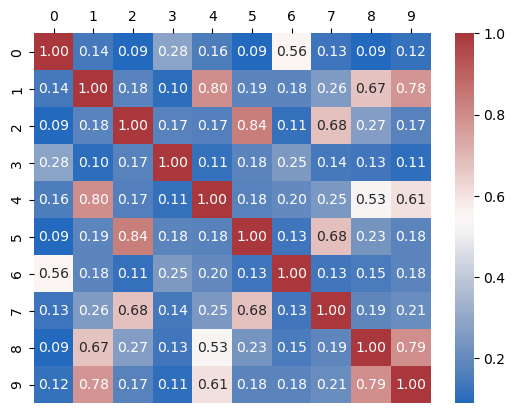

In [49]:
similarity_matrix = tanimoto_matrix(list_fingerprints) # Solo para los 10 primeros compuestos
ax = sns.heatmap(similarity_matrix, annot=True, fmt='.2f', cmap="vlag") # annot= True imprime el coeficiente de Tanimoto y fmt='.2f' me da solo dos decimales
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()

#### Agrupamiento por distancias
Como lo explicamos inicialmente, el **agrupamiento por aglomeración** consiste en fusionar consecutivamente aquellos clústers que estén más cercados, para entender el agrupamiento podemos utilizar el método [`linkage`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage), el cual crea una *matriz de enlace* (linkage matrix) con el orden con el cual se agruparon los diferentes clústers (por defecto, la metrica de medida es la *distancia euclideana* y el método de agrupamiento es el *punto más cercano*), nosotros vamos a trabajar con la distancia media de los elementos del agrupamiento (*average*).

In [50]:
# Realizar el clustering jerárquico utilizando el método de enlace promedio (average linkage)
# 'similarity_matrix' es la matriz de similitud de Tanimoto calculada previamente
Z = linkage(similarity_matrix, method='average')

# Mostrar la estructura del clustering jerárquico resultante
Z

array([[ 2.        ,  5.        ,  0.23554759,  2.        ],
       [ 8.        ,  9.        ,  0.34334866,  2.        ],
       [ 1.        ,  4.        ,  0.36466205,  2.        ],
       [ 7.        , 10.        ,  0.50012338,  3.        ],
       [11.        , 12.        ,  0.57159297,  4.        ],
       [ 0.        ,  6.        ,  0.63974664,  2.        ],
       [ 3.        , 15.        ,  1.08456092,  3.        ],
       [13.        , 16.        ,  1.55505923,  6.        ],
       [14.        , 17.        ,  1.6118122 , 10.        ]])

En la *i-ésima* fila, `Z[i,0]` y `Z[i,1]` indican los clusters que son combinaron para formar el clúster $n+i$. `Z[i,2]` indica la distancia entre los clústers y `Z[i,3]` representa el número de compuestos del nuevo clúster.
Recordemos que iniciamos con diez clústers enumerados del 0 al 9 (las diez moléculas iniciales), así, las filas de la matriz de enlace Z son:
- **fila-0**: Se crea el clúster 10, conformado por la molécula 1 (clúster 1) y la mólecula 5 (clúster 5), la distancia entre el clúster 1 y 5 es de 0.235548, y el nuevo clúster tiene 2 moléculas
- **fila-1**: Se crea el clúster 11, conformado por la molécula 8 (clúster 8) y la mólecula 9 (clúster 9), la distancia entre el clúster 8 y 9 es de 0.343349, y el nuevo clúster tiene 2 moléculas
- **fila-2**: Se crea el clúster 12, conformado por la molécula 2 (clúster 2) y la mólecula 7 (clúster 7), la distancia entre el clúster 2 y 7 es de 0.364662, y el nuevo clúster tiene 2 moléculas
- **fila-3**: Se crea el clúster 13, conformado por la molécula 4 (clúster 4) y el clúster 10 (creado en la **fila-0**), la distancia entre el clúster 4 y 10 es de 0.500123, y el nuevo clúster tiene 3 moléculas
- **fila-4**: Se crea el clúster 14, conformado por el clúster 11 (creado en la **fila-1**) y el clúster 12 (creado en la **fila-2**), la distancia entre el clúster 11 y 12 es de 0.571593, y el nuevo clúster tiene 4 moléculas
- **fila-5**: Se crea el clúster 15, conformado por la molécula 0 (clúster 0) y la mólecula 6 (clúster 6), la distancia entre el clúster 0 y 6 es de 0.639747, y el nuevo clúster tiene 2 moléculas
- **fila-6**: Se crea el clúster 16, conformado por la molécula 3 (clúster 3) y el clúster 15 (creado en la **fila-5**), la distancia entre el clúster 3 y 15 es de 1.084561, y el nuevo clúster tiene 3 moléculas
- **fila-7**: Se crea el clúster 17, conformado por el clúster 13 (creado en la **fila-3**) y el clúster 16 (creado en la **fila-6**), la distancia entre el clúster 13 y 16 es de 1.555059, y el nuevo clúster tiene 6 moléculas
- **fila-8**: Se crea el clúster 18, conformado por el clúster 14 (creado en la **fila-4**) y el clúster 17 (creado en la **fila-17**), la distancia entre el clúster 14 y 17 es de 1.611812, y el nuevo clúster tiene 10 moléculas

#### Representación: el *dendograma*
La manera de representar un agrupamiento jerárquico es con un dendrograma

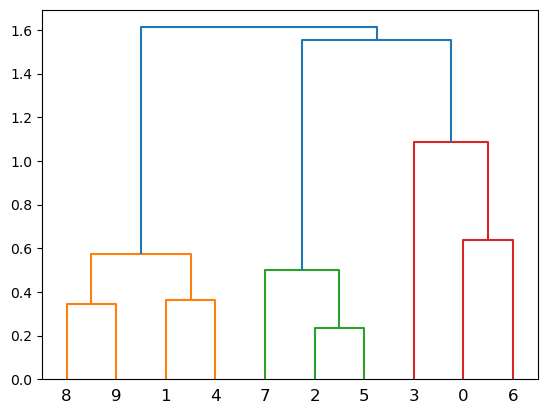

In [51]:
# Generar el dendrograma a partir de la matriz de clustering 'Z'
dn = dendrogram(Z)

Las líneas verticales del dendrograma ilustran las fusiones (o divisiones) realizadas en cada etapa del agrupamiento. Podemos ver la distancia, los distintos niveles de asociaciones entre los datos individuales y también las asociaciones entre clústers. Recordemos que la distancia utilizada fue la euclidiana, la cual podemos modificar cuando armamos Z.

#### Clustermap
Todo lo anterior se puede organizar en una matriz y graficar por medio de un mapa de calor de agrupamiento jerárquico, note que el orden de los compuestos no necesariamente es el mismo orden que el del dendograma

/Users/jessicavalero/anaconda3/envs/chemo/lib/python3.8/site-packages/fastcluster.py:26: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  from numpy import double, empty, array, ndarray, var, cov, dot, bool, \
/Users/jessicavalero/anaconda3/envs/chemo/lib/python3.8/site-packages/fastcluster.py:26: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  from numpy import double, empty, array, ndarray, var, cov, dot, bool, \


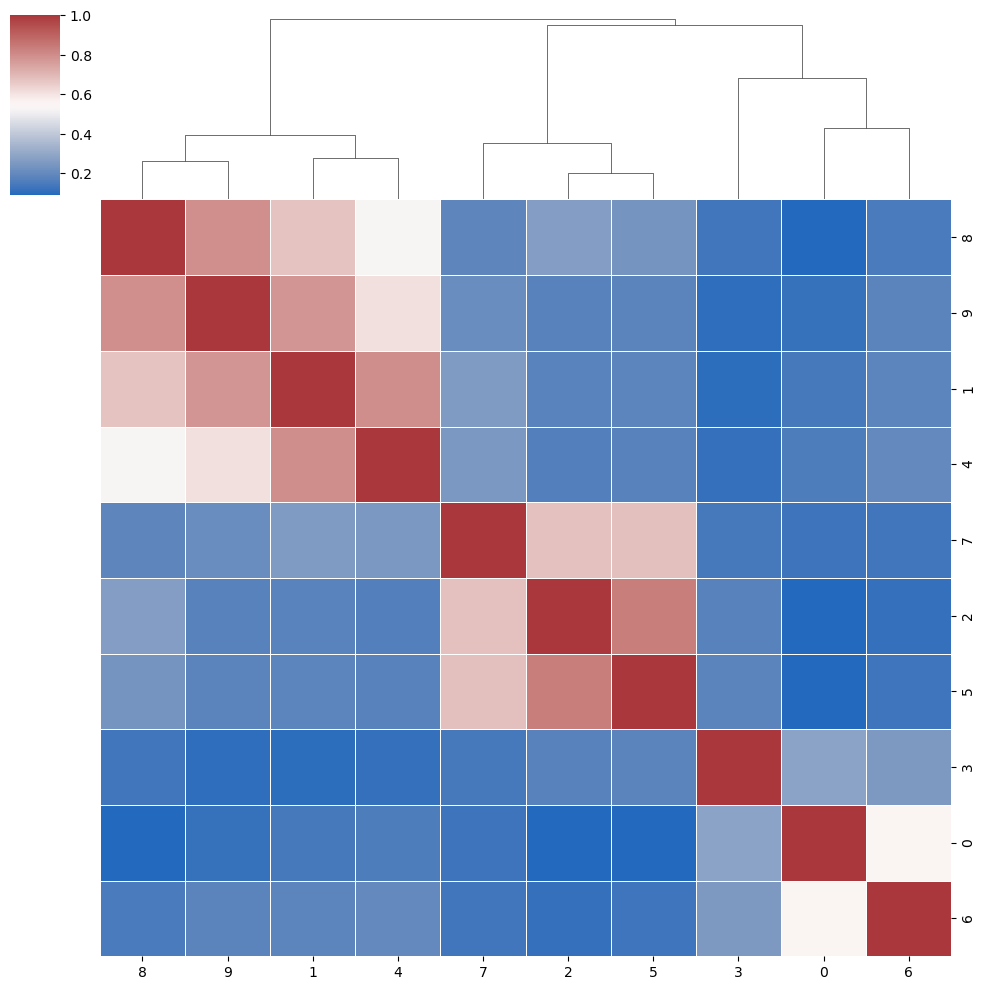

In [52]:
# Crear un clustermap (mapa de calor con clustering jerárquico) basado en la matriz de similitud de Tanimoto
g = sns.clustermap(similarity_matrix, method='average',
                   cmap="vlag",  # Mapa de colores
                   dendrogram_ratio=(.1, .2),  # Proporción del dendrograma en los ejes (filas, columnas)
                   linewidths=.5)  # Grosor de las líneas de separación en el mapa de calor

# Eliminar el dendrograma de las filas para una visualización más clara
g.ax_row_dendrogram.remove()

#### Umbral de agrupamiento
Podemos utilizar la distancia entre los clústers como **límite** para agrupar los compuestos, por ejemplo, si elegimos agrupar con una distancia es menor o igual que 0.6, se formarían 5 grupos con los siguientes compuestos:
- Clúster-1: (1, 4, 8, 9)
- Clúster-2: (7, 2, 5)
- Clúster-3: 3
- Clúster-4: 0
- Clúster-5: 6

El método ['fcluster'](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster) organiza un arreglo de $n$ elementos, donde cada elemento indica número del clúster al que pertenece el compuesto de esa posición

In [95]:
# Realizar el clustering jerárquico sobre la matriz de similitud de Tanimoto
Z = linkage(similarity_matrix)

# Obtener los clusters a partir de la matriz de enlace Z
# 't=0.6' define el umbral de distancia para la formación de clusters
# 'criterion="distance"' indica que se usará la distancia de enlace para definir los clusters
fcluster(Z, t=0.6, criterion='distance')

array([3, 1, 2, 5, 1, 2, 4, 2, 1, 1], dtype=int32)

### Algoritmo de agrupamiento *Butina*: Centroides y esferas de exclusión
Un algoritmo utilizado comunmente para agrupar moléculas es el conocido como el *algortimo de agrupamiento Butina* (Butina clustering algorithm)<sup> **5** </sup>

Podemos utilizar la librería `rdkit` para implementar este algorítmo (`Butina.ClusterData`). Como entrada se necesita una lista con las distancias de Tanimoto de los compuestos. Esta lista la podemos encontrar a partir de la matriz de similitud de Tanimoto donde las distancias se pueden hallar con la fórmula $distancia = 1 - similitud$.

Para armar la lista podemos utilizar la función de la matriz de tanimoto, separar solamente los elementos que están debajo de la diagonal principal y hallar la distancia

In [97]:
similarity_matrix = tanimoto_matrix(list_fingerprints)  # Matriz de similitud
a, b = np.tril_indices(len(list_fingerprints), -1)  # índices de los elementos debajo de la diagonal principal
dist_similarity_matrix = 1 - similarity_matrix[a, b]  # distancias de los compuestos

Ahora escogemos un umbral de distancia para realizar el agrupamiento, por ejemplo, si escogemos como umbral 0.4, se obtienen cinco clústers.

In [55]:
# Aplicar el algoritmo de clustering de Butina basado en la matriz de similitud
# 'dist_similarity_matrix' es la matriz de similitud de Tanimoto transformada en una matriz de distancia
# 'len(list_fingerprints)' es el número total de fingerprints a considerar
# 'distThresh=0.4' establece un umbral de distancia para definir los clusters
# 'isDistData=True' indica que los datos de entrada son una matriz de distancias
clusters = Butina.ClusterData(dist_similarity_matrix, len(list_fingerprints), distThresh=0.4, isDistData=True)

# Ordenar los clusters por tamaño en orden descendente (los más grandes primero)
clusters = sorted(clusters, key=len, reverse=True)

# Mostrar los clusters obtenidos
clusters


[(9, 1, 4, 8), (7, 2, 5), (6,), (3,), (0,)]

**Observación**: Aunque el agrupamiento es similar al encontrado con el método `fcluster` note que el umbral utilizado es diferente, adicionalmente, el algoritmo de `Butina` determina el *centroide* del clúster, el cual será similar a cualquier otra molécula del clúster de acuerdo al valor del umbral dado. El primer elemento de cada clúster es el centroide.

## Método del codo (Elbow Method)
Uno de los problemas que nos encontramos a la hora de aplicar el agrupamiento es la elección del número de Clusters. No existe un criterio objetivo ni ampliamente válido para la elección de un número óptimo de Clusters; pero tenemos que tener en cuenta, que una mala elección de los mismos puede dar lugar a realizar agrupaciones de datos muy heterogéneos (pocos Clusters); o datos, que siendo muy similares unos a otros los agrupemos en Clusters diferentes (muchos Clusters).

El método del codo utiliza los valores de la inercia obtenidos tras aplicar el agrupamiento para diferentes números de clusters (desde 1 a N Clusters), siendo la **inercia** la *suma de las distancias al cuadrado de cada objeto del Cluster a su centroide*. Luego, podemos hallar el *promedio* de las inercias para cada N (comúnmente llamado *distorsión*) y representamos en una gráfica la distorsión respecto al número de clústers<sup> **6** </sup>. La gráfica nos dirve para apreciar el cambio y a partir de esta podemos estimar el número óptimo de clústers a seleccionar.

Comenzamos definiendo una función que determine la inercia y distorsión, ya que vamos a utilizar el método de Butina para hacer el clústering, debemos tener en cuenta que este depende del *umbral de similitud* y a partir de este umbral se halla el número de clústers (entre más pequeño sea el umbral, más clústers, pues es menor la cantidad de moléculas similares).

In [101]:
# Define una función llamada 'distorion_tanimoto' que calcula la distorsión de Tanimoto para un conjunto de clusters.
def distorion_tanimoto(clusters, full_dataset):
    # Inicializa una lista vacía llamada 'inertia' para almacenar las inercias de cada clúster.
    inertia = list()

    # Itera sobre cada clúster en la lista 'clusters'.
    for cluster in clusters:
        # Crea un subconjunto del DataFrame 'full_dataset' correspondiente a las moléculas en el clúster actual.
        # 'cluster' contiene los índices de las moléculas pertenecientes al clúster.
        # 'full_dataset.iloc[list(cluster)]' selecciona las filas del DataFrame usando estos índices.
        cluster_dataset = full_dataset.iloc[list(cluster)]

        # Selecciona el fingerprint de la primera molécula del clúster como el "centroide" del clúster.
        circular_fp_query = cluster_dataset['morgan_fp'].iloc[0]

        # Crea una lista de los fingerprints de todas las moléculas en el clúster.
        circular_fp_list = list(cluster_dataset['morgan_fp'])

        # Calcula el cuadrado de la distancia Tanimoto entre el centroide y cada molécula del clúster.
        # DataStructs.BulkTanimotoSimilarity calcula la similitud Tanimoto entre el centroide y todos los demás.
        # (1 - similitud) da la distancia, y luego se eleva al cuadrado.
        sqrt_dist_to_centroid = (1 - np.array(DataStructs.BulkTanimotoSimilarity(circular_fp_query, circular_fp_list)))**2

        # Calcula la suma de los cuadrados de las distancias de cada molécula al centroide del clúster.
        # Esta suma representa la inercia del clúster, una medida de cuán dispersos están los puntos dentro del clúster.
        inertia.append(sum(sqrt_dist_to_centroid))

    # Calcula la media de las inercias de todos los clústeres.
    # Esta media representa la distorsión total de la partición, una medida de cuán bien los clústeres representan los datos.
    distortion = np.mean(inertia)
    
    # Devuelve el número de clústeres y la distorsión.
    return len(clusters), distortion


Ahora repetimos el proceso anterior, variando el umbral de similitud de 0 a 1 con pasos de 0.05 (*observe la linea 7: `np.arange(0,1,0.05)`*), luego creamos una tabla de resultados para poder graficarlos

In [102]:
# Inicializa una lista vacía llamada 'result' para almacenar los resultados del análisis de clustering.
result = list()

# Crea un subconjunto del DataFrame 'molecule_dataset' que contiene las primeras 10 moléculas.
molecule_mini_dataset = molecule_dataset[:10]

# Extrae la columna de fingerprints de Morgan ('morgan_fp') del subconjunto de datos y la asigna a la variable 'list_fingerprints'.
list_fingerprints = molecule_mini_dataset['morgan_fp']

# Calcula la matriz de similitud de Tanimoto entre los fingerprints en 'list_fingerprints' utilizando la función 'tanimoto_matrix'.
# El resultado es una matriz cuadrada donde cada elemento (i, j) representa la similitud entre el fingerprint i y el fingerprint j.
similarity_matrix = tanimoto_matrix(list_fingerprints)  # Matriz de similitud

# Genera los índices de las posiciones que están por debajo de la diagonal principal de una matriz cuadrada.
# 'a' contiene los índices de las filas, y 'b' contiene los índices de las columnas.
# El argumento '-1' asegura que la diagonal principal no se incluya.
a, b = np.tril_indices(len(list_fingerprints), -1)  # índices de los elementos debajo de la diagonal principal

# Calcula la matriz de distancias a partir de la matriz de similitud.
# La distancia se calcula como 1 - similitud.  Esto convierte las similitudes en distancias,
# donde una similitud de 1 (máxima similitud) corresponde a una distancia de 0, y una similitud de 0
# (mínima similitud) corresponde a una distancia de 1.  Luego, se seleccionan solo las distancias
# correspondientes a la parte triangular inferior de la matriz (excluyendo la diagonal) usando los índices 'a' y 'b'.
dist_similarity_matrix = 1 - similarity_matrix[a, b] # distancias de los compuestos

# Itera sobre un rango de valores de umbral (cutoff) de 0 a 1 con un incremento de 0.05.
for i in np.arange(0,1,0.05):
    # Redondea el valor del umbral a 2 decimales.
    cutoff = round(i,2)

    # Realiza el clustering de Butina utilizando la matriz de distancias y el umbral actual.
    # 'dist_similarity_matrix' contiene las distancias entre los compuestos.
    # 'len(list_fingerprints)' es el número de compuestos.
    # 'distThresh' es el umbral de distancia para formar los clusters.
    # 'isDistData=True' indica que los datos de entrada son distancias, no similitudes.
    clusters = Butina.ClusterData(dist_similarity_matrix,len(list_fingerprints), distThresh=cutoff, isDistData=True)

    # Calcula el número de clusters ('n') y la distorsión ('dist') para el clustering actual.
    # La distorsión es una medida de cuán bien los clusters representan los datos.
    n, dist = distorion_tanimoto(clusters, molecule_mini_dataset)

    # Agrega los resultados (cutoff, número de clusters, distorsión) a la lista 'result'.
    result.append((cutoff, n, dist))

# Crea un DataFrame de Pandas llamado 'table' a partir de la lista 'result'.
# Las columnas del DataFrame son 'cutoff', 'N_clusters' y 'distortion'.
table = pd.DataFrame(result, columns=['cutoff', 'N_clusters', 'distortion'])

# Imprime el DataFrame 'table'.
# Este DataFrame contiene los resultados del análisis de clustering para diferentes valores de umbral.
print(table)


    cutoff  N_clusters  distortion
0     0.00          10    0.000000
1     0.05          10    0.000000
2     0.10          10    0.000000
3     0.15          10    0.000000
4     0.20           9    0.002986
5     0.25           7    0.016977
6     0.30           7    0.016977
7     0.35           5    0.080844
8     0.40           5    0.090140
9     0.45           4    0.162058
10    0.50           4    0.162058
11    0.55           4    0.162058
12    0.60           4    0.162058
13    0.65           4    0.162058
14    0.70           4    0.162058
15    0.75           3    0.590061
16    0.80           3    0.751878
17    0.85           2    1.858372
18    0.90           1    4.472966
19    0.95           1    4.472966


<Axes: xlabel='N_clusters'>

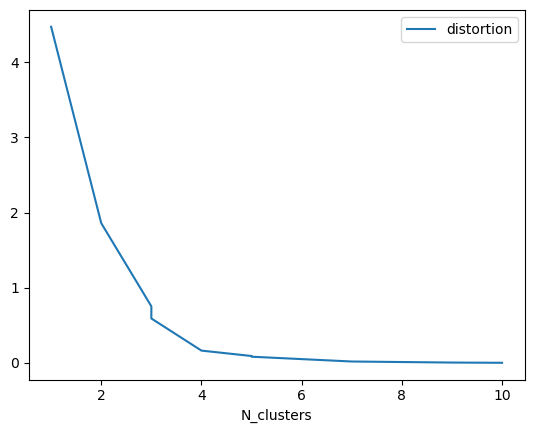

In [103]:
# Graficar la distorsión promedio intra-cluster en función del número de clusters
# ---------------------------------------------------------------
# Este gráfico permite visualizar cómo cambia la distorsión (1 - similitud media)
# al variar el número de clusters generados con diferentes umbrales de corte (cutoff).
# Un buen valor de "cutoff" se encuentra típicamente donde se balancea
# un número razonable de clusters con una baja distorsión.
# ---------------------------------------------------------------
table.plot(x='N_clusters', y='distortion')

La gráfica muestra que cuando el número de clústers es `N=4` hay un cambio brusco (como si fuera el codo de un brazo), por tanto, podemos escoger este como el número óptimo de clústers. Al revisar la tabla vemos que el umbral que debemos escoger es `cutoff=0.45`.

## Agrupamiento jeráquico del total de datos
Podemos utilizar lo aprendido con el agrupamiento de diez compuestos para representar el agrupamiento de todo el conjunto de compuestos.

Iniciemos encontrando la matriz de similitud de Tanimoto, ya que son 2605 compuestos, la matriz de similitud tiene un tamaño de 2605 x 2605

**Observación**: la variable *circular_fp_list* tiene la lista de todas las fingerprints de los compuestos

In [104]:
# Calcular la matriz de similitud de Tanimoto para todas las moléculas en la lista de fingerprints
# ----------------------------------------------------------------------------
# Esta matriz es cuadrada (n x n), donde n es el número total de moléculas.
# Cada elemento [i, j] de la matriz representa la similitud de Tanimoto entre la molécula i y la j.
# La similitud de Tanimoto compara la superposición entre dos vectores binarios (fingerprints).
# ----------------------------------------------------------------------------
similarity_matrix_full = tanimoto_matrix(circular_fp_list)

# Mostrar la forma (dimensiones) de la matriz de similitud
# Debe devolver una tupla (n, n), confirmando que hay una fila y columna por molécula
similarity_matrix_full.shape

(2697, 2697)

Observemos el mapa de calor de la matriz de similitud, la cual aún no está organizada

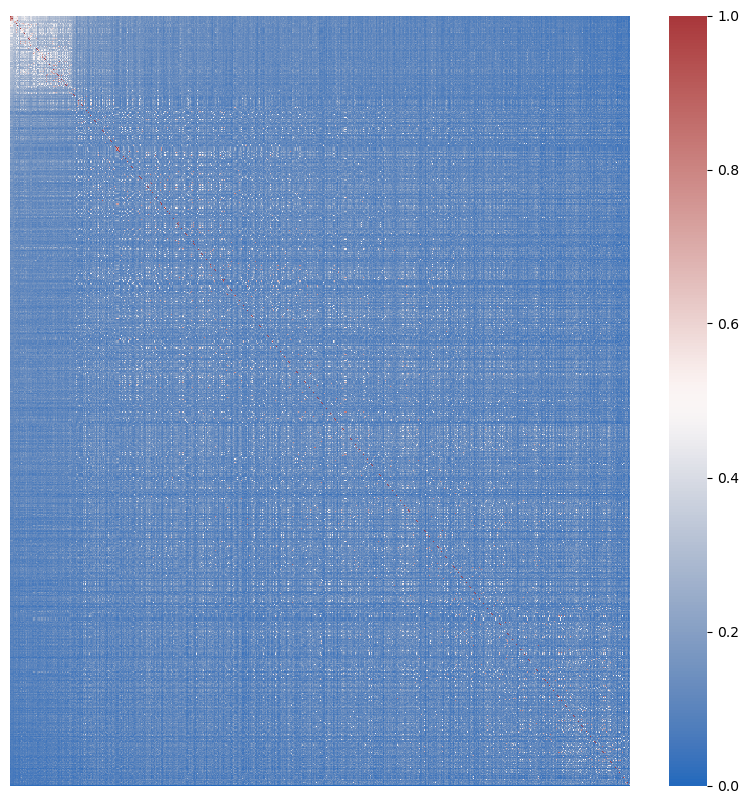

In [105]:
# Crear una figura y ejes para visualizar la matriz de similitud
# --------------------------------------------------------------
# figsize=(10, 10) define el tamaño de la figura en pulgadas.
# Esto es útil para evitar que una matriz grande se vea comprimida o ilegible.
fig, ax = plt.subplots(figsize=(10, 10))

# Dibujar la matriz de similitud como un mapa de calor (heatmap)
# --------------------------------------------------------------
# sns.heatmap visualiza los valores de la matriz como colores.
# cmap="vlag" define la paleta de colores, que en este caso es divergente
# (útil para representar diferencias centradas en un valor medio, como la similitud ~0.5).
# yticklabels=False y xticklabels=False eliminan las etiquetas de los ejes para una vista más limpia,
# especialmente útil cuando se visualiza una gran cantidad de moléculas.
ax = sns.heatmap(similarity_matrix_full, cmap="vlag",
                 yticklabels=False, xticklabels=False)


### Agrupación: Algoritmo de agrupamiento Butina
Similar a la agrupación realizada con los diez compuestos, vamos a crear una función en donde podemos decidir el umbral de la distancia de Tanimoto, por ejemplo, supongamos que queremos agrupar moléculas cuya similitud es menor o igual a *cutoff*=0.2.
**Observación**: Recordemos que estamos utilizando el algoritmo de agrupamiento *Butina*

In [106]:
# Define una función llamada 'cluster_fingerprints' que realiza el agrupamiento de fingerprints basado en la similitud de Tanimoto.
def cluster_fingerprints(fp_list, cutoff=0.2):
    # Calcula la matriz de similitud de Tanimoto para la lista de fingerprints proporcionada.
    # El resultado es una matriz cuadrada donde cada elemento (i, j) representa la similitud entre el fingerprint i y el fingerprint j.
    similarity_matrix = tanimoto_matrix(fp_list)  # Matriz de similitud

    # Calcula las distancias entre los compuestos a partir de la matriz de similitud.
    # 'np.tril_indices' genera los índices para la parte triangular inferior de la matriz (sin la diagonal).
    # La distancia se calcula como 1 - similitud.
    a, b = np.tril_indices(len(fp_list), -1)
    dist_similarity_matrix = 1 - similarity_matrix[a, b]

    # Agrupa los datos utilizando el algoritmo de clustering de Butina.
    # 'dist_similarity_matrix' contiene las distancias entre los fingerprints.
    # 'len(fp_list)' es el número total de fingerprints.
    # 'cutoff' es el umbral de distancia para formar un cluster; los puntos dentro de este umbral se agrupan.
    # 'isDistData=True' indica que se están proporcionando distancias, no similitudes.
    clusters = Butina.ClusterData(dist_similarity_matrix, len(fp_list), cutoff, isDistData=True)

    # Ordena los clusters en orden descendente según su tamaño (número de elementos).
    # Esto permite identificar fácilmente los clusters más grandes.
    clusters = sorted(clusters, key=len, reverse=True)

    # Devuelve la lista de clusters ordenados.  Cada cluster es una lista de índices que indican qué fingerprints pertenecen a ese cluster.
    return clusters


Al ejecutar la función *cluster_fingerprints* se crean los agrupamientos, iniciando por aquellos que mayor cantidad de moléculas tiene, veamos los 10 primeros.

In [107]:
# Ejecutar el procedimiento de agrupación para el conjunto de datos, distancia: 0.2
clusters = cluster_fingerprints(morgan_fp_list, cutoff=0.2)
# Clústers más grandes
print(clusters[:10])

[(1090, 531, 699, 716, 725, 729, 834, 836, 840, 890, 1043, 1094, 1169, 1298), (1849, 241, 547, 1396, 1448, 1469, 1519, 1663, 1682, 1765, 1886), (1575, 1210, 1754, 1881, 1907, 2003, 2020, 2123, 2206, 2346, 2417), (652, 176, 240, 292, 581, 730, 797, 886, 1025, 1099, 1271), (2587, 2513, 2514, 2519, 2531, 2536, 2569, 2578, 2611, 2617), (446, 217, 255, 422, 583, 722, 744, 770, 837, 980), (1372, 995, 1065, 1162, 1167, 1240, 1285, 1305, 1345), (1016, 562, 756, 875, 884, 895, 905, 922, 991), (590, 69, 74, 90, 121, 163, 276, 299, 306), (467, 180, 207, 247, 314, 320, 509, 550, 692)]


Como estamos trabajando con un conjunto grande de datos, no es buena idea imprimir toda la lista de los clústers, sin embargo, podemos resumir la información en una tabla de frecuencias.

In [108]:
# Obtener el tamaño de cada grupo (número de elementos en cada cluster)
# 'clusters' es una lista de listas, donde cada sublista contiene los índices de las moléculas en ese cluster
agrup = list(map(len, clusters))

# Calcular cuántos clusters tienen la misma cantidad de elementos
# np.unique devuelve los valores únicos (tamaños de cluster) y cuántas veces se repiten
unique, counts = np.unique(agrup, return_counts=True)

# Crear una tabla de frecuencias donde:
# - Cada fila representa un tamaño de cluster y su frecuencia
# - np.flip invierte el orden de las filas para mostrar los clusters grandes primero
frec_table = np.flip(np.array([unique, counts]).T)  # orden invertido para claridad

# Mostrar la tabla: cada fila indica [tamaño del cluster, cantidad de clusters de ese tamaño]
frec_table

array([[   1,   14],
       [   3,   11],
       [   2,   10],
       [   6,    9],
       [   5,    8],
       [   6,    7],
       [  14,    6],
       [  20,    5],
       [  34,    4],
       [  79,    3],
       [ 208,    2],
       [1521,    1]])

Podemos ver que el clúster más grande (el primero) tiene 14 elementos y que hay 1494 compuestos que no se agruparon (clústers individuales)
Veamos gráficamente la cantidad de elementos en los clústers de mayor tamaño y cuántos hay de cada uno

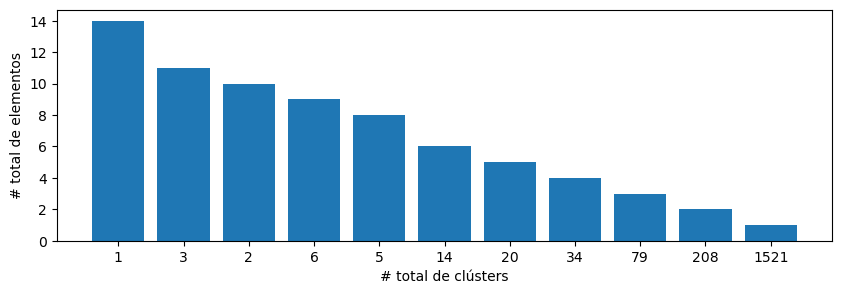

In [109]:
# Configura la figura y los ejes para un gráfico de barras utilizando matplotlib.
# 'figsize' especifica el tamaño de la figura en pulgadas (ancho x alto).
fig, ax = plt.subplots(figsize=(10, 3))  # Configurar la figura de matplotlib

# Crea un gráfico de barras.
# 'list(map(str, frec_table[:, 0]))' convierte los valores del primer columna de frec_table a cadenas and use it as x-axis.
# 'frec_table[:, 1]' proporciona los valores de la segunda columna de frec_table para el eje y (alturas de las barras).
ax.bar(list(map(str, frec_table[:, 0])), frec_table[:, 1])

# Establece la etiqueta del eje x del gráfico.
ax.set_xlabel("# total de clústers")

# Establece la etiqueta del eje y del gráfico.
ax.set_ylabel("# total de elementos")

# Muestra el gráfico en pantalla.
plt.show()

# Cierra la figura para liberar memoria.
plt.close()


Podemos examinar con más detalle el primer clúster de 14 elementos:

In [110]:
# Convierte el primer cluster (índice 0) de 'clusters' a una lista de índices.
list_ind_cluster0 = list(clusters[0])

# Utiliza los índices del primer clúster para seleccionar las filas correspondientes del DataFrame 'molecule_dataset'.
# El resultado es un nuevo DataFrame, 'molecules_cluster0', que contiene solo las moléculas que pertenecen al primer clúster.
molecules_cluster0 = molecule_dataset.iloc[list_ind_cluster0]

# Imprime el DataFrame 'molecules_cluster0'.
# Esto muestra las moléculas que forman parte del primer clúster.
molecules_cluster0


,molecule_chembl_id,smiles,ROMol,morgan_fp
1090,CHEMBL4749678,CNC(=O)c1sc(-c2ccnc(NC(=O)CNCCNc3c4c(nc5ccccc3...,<rdkit.Chem.rdchem.Mol object at 0x178b98350>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
531,CHEMBL4789145,CNC(=O)c1sc(-c2ccnc(NC(=O)CNCCNc3c4c(nc5ccccc3...,<rdkit.Chem.rdchem.Mol object at 0x178b88ac0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
699,CHEMBL4785004,CNC(=O)c1sc(-c2ccnc(NC(=O)CNCCNc3c4c(nc5ccc(OC...,<rdkit.Chem.rdchem.Mol object at 0x178b8d580>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
716,CHEMBL4749327,CNC(=O)c1sc(-c2ccnc(NC(=O)CNCCNc3c4c(nc5ccccc3...,<rdkit.Chem.rdchem.Mol object at 0x178b8dcf0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
725,CHEMBL4756997,CNC(=O)c1sc(-c2ccnc(NC(=O)CNCCCCNc3c4c(nc5cccc...,<rdkit.Chem.rdchem.Mol object at 0x178b8e120>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
729,CHEMBL4753347,NC(=O)c1sc(-c2ccnc(NC(=O)CNCCNc3c4c(nc5ccccc35...,<rdkit.Chem.rdchem.Mol object at 0x178b8e2e0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
834,CHEMBL4798419,CNC(=O)c1sc(-c2ccnc(NC(=O)CNCCCCCCCCNc3c4c(nc5...,<rdkit.Chem.rdchem.Mol object at 0x178b91190>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
836,CHEMBL4800403,CNC(=O)c1sc(-c2ccnc(NC(=O)CNCCCCCCNc3c4c(nc5cc...,<rdkit.Chem.rdchem.Mol object at 0x178b91270>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
840,CHEMBL4777788,CNC(=O)c1sc(-c2ccnc(NC(=O)CNCCNc3c4c(nc5cc(Cl)...,<rdkit.Chem.rdchem.Mol object at 0x178b91430>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
890,CHEMBL4787169,CNC(=O)c1sc(-c2ccnc(NC(=O)CNCCNc3c4c(nc5ccccc3...,<rdkit.Chem.rdchem.Mol object at 0x178b92a50>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


14 moleculas del clúster de mayor tamaño


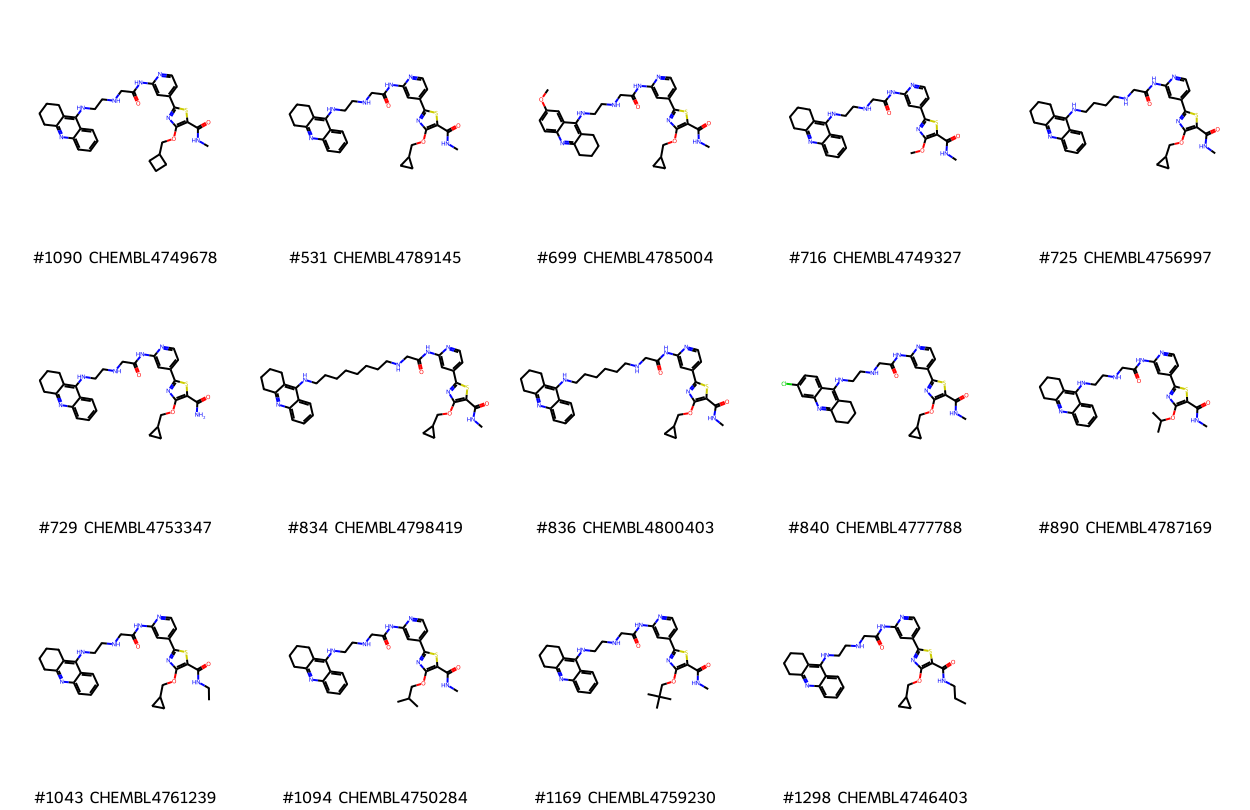

In [111]:
# Imprime el número de moléculas en el DataFrame 'molecules_cluster0', junto con un mensaje descriptivo.
print(f'{len(molecules_cluster0)} moleculas del clúster de mayor tamaño')

# Crea una lista de leyendas para las moléculas que se van a dibujar en la imagen de la cuadrícula.
# Itera sobre las filas del DataFrame 'molecules_cluster0'.
# Para cada molécula, formatea una cadena que incluye el índice de la fila y el valor de la columna 'molecule_chembl_id'.
legends = [
    f"#{index} {molecule['molecule_chembl_id']}"
    for index, molecule in molecules_cluster0.iterrows()
]

# Genera una imagen de cuadrícula que muestra las moléculas del primer clúster.
# 'mols' es una lista de objetos Mol de RDKit para dibujar, obtenida de la columna "ROMol" de 'molecules_cluster0'.
# 'legends' es la lista de cadenas creadas anteriormente, que se utilizan para etiquetar cada molécula en la cuadrícula.
# 'molsPerRow' especifica el número de moléculas por fila en la cuadrícula.
# 'subImgSize' especifica el tamaño de cada subimagen (molécula) en la cuadrícula.
Chem.Draw.MolsToGridImage(
    mols= molecules_cluster0["ROMol"].tolist(),
    legends=legends,
    molsPerRow=5,
    subImgSize=(250, 270),
)


También podemos tener un breve informe sobre el número de grupos y sus tamaños, dependiendo del tamaño del cúlster:

In [112]:
# Calcula el número de clústeres que contienen exactamente 1 compuesto.
# Itera a través de la lista 'clusters', donde cada elemento 'c' es un clúster (una lista de índices).
# La expresión 'len(c) == 1' verifica si el tamaño del clúster es 1.
# 'sum(...)' cuenta cuántas veces esta condición es verdadera.
num_clust_g1 = sum(1 for c in clusters if len(c) == 1)

# Calcula el número de clústeres que contienen más de 5 compuestos.
# Similar al anterior, pero la condición es 'len(c) > 5'.
num_clust_g5 = sum(1 for c in clusters if len(c) > 5)

# Calcula el número de clústeres que contienen más de 10 compuestos.
# Similar a los anteriores, pero la condición es 'len(c) > 10'.
num_clust_g10 = sum(1 for c in clusters if len(c) > 10)

# Imprime el número total de clústeres.
print("Número total de clústeres: ", len(clusters))

# Imprime el número de clústeres con solo 1 compuesto.
print("# clusters con solo 1 compuesto: ", num_clust_g1)

# Imprime el número de clústeres con más de 5 compuestos.
print("# clusters con >5 compuestos: ", num_clust_g5)

# Imprime el número de clústeres con más de 10 compuestos.
print("# clusters con >10 compuestos: ", num_clust_g10)


Número total de clústeres:  1899
# clusters con solo 1 compuesto:  1521
# clusters con >5 compuestos:  37
# clusters con >10 compuestos:  4


#### Número óptimo de clústers y umbral de similitid

Utilizando el algoritmo que usamos para los diez elementos, podemos hallar la *distorsión* para diferentes números de clúster (`N`).


In [113]:
# Inicializa una lista vacía llamada 'result' para almacenar los resultados del análisis de clustering.
result = list()

# Asigna la columna de fingerprints de Morgan del DataFrame molecule_dataset a la variable list_fingerprints.
# A diferencia del fragmento anterior, este utiliza el DataFrame completo, no solo las primeras 10 filas.
list_fingerprints = molecule_dataset['morgan_fp']

# Calcula la matriz de similitud de Tanimoto entre los fingerprints en list_fingerprints.
# El resultado es una matriz cuadrada donde cada elemento (i, j) representa la similitud entre el fingerprint i y el fingerprint j.
similarity_matrix = tanimoto_matrix(list_fingerprints)  # Matriz de similitud

# Genera los índices de las posiciones que están por debajo de la diagonal principal de una matriz cuadrada.
# 'a' contiene los índices de las filas, y 'b' contiene los índices de las columnas.
# El argumento '-1' asegura que la diagonal principal no se incluya.
a, b = np.tril_indices(len(list_fingerprints), -1)  # índices de los elementos debajo de la diagonal principal

# Calcula la matriz de distancias a partir de la matriz de similitud.
# La distancia se calcula como 1 - similitud. Esto convierte las similitudes en distancias,
# donde una similitud de 1 (máxima similitud) corresponde a una distancia de 0, y una similitud de 0
# (mínima similitud) corresponde a una distancia de 1. Luego, se seleccionan solo las distancias
# correspondientes a la parte triangular inferior de la matriz (excluyendo la diagonal) usando los índices 'a' y 'b'.
dist_similarity_matrix = 1 - similarity_matrix[a, b] # distancias de los compuestos

# Itera sobre un rango de valores de umbral (cutoff) de 0 a 1 con un incremento de 0.05.
for i in np.arange(0,1,0.05):
    # Redondea el valor del umbral a 2 decimales.
    cutoff = round(i,2)

    # Realiza el clustering de Butina utilizando la matriz de distancias y el umbral actual.
    # 'dist_similarity_matrix' contiene las distancias entre los compuestos.
    # 'len(list_fingerprints)' es el número total de compuestos.
    # 'distThresh' es el umbral de distancia para formar los clusters; los puntos dentro de este umbral se agrupan.
    # 'isDistData=True' indica que los datos de entrada son distancias, no similitudes.
    clusters = Butina.ClusterData(dist_similarity_matrix,len(list_fingerprints), distThresh=cutoff, isDistData=True)

    # Calcula el número de clusters ('n') y la distorsión ('dist') para el clustering actual.
    # La distorsión es una medida de cuán bien los clusters representan los datos.  Aquí, se utiliza el dataset completo.
    n, dist = distorion_tanimoto(clusters, molecule_dataset)

    # Agrega los resultados (cutoff, número de clusters, distorsión) a la lista 'result'.
    result.append((cutoff, n, dist))

# Crea un DataFrame de Pandas llamado 'table' a partir de la lista 'result'.
# Las columnas del DataFrame son 'cutoff', 'N_clusters' y 'distortion'.
table = pd.DataFrame(result, columns=['cutoff', 'N_clusters', 'distortion'])

# Imprime el DataFrame 'table'.
# Este DataFrame contiene los resultados del análisis de clustering para diferentes valores de umbral.
print(table)


    cutoff  N_clusters  distortion
0     0.00        2604    0.000000
1     0.05        2565    0.000014
2     0.10        2492    0.000238
3     0.15        2302    0.001822
4     0.20        1899    0.010048
5     0.25        1502    0.031032
6     0.30        1176    0.071083
7     0.35         919    0.141486
8     0.40         741    0.240713
9     0.45         607    0.394717
10    0.50         506    0.609482
11    0.55         428    0.903923
12    0.60         348    1.380234
13    0.65         296    2.022871
14    0.70         253    2.865567
15    0.75         176    5.837724
16    0.80         100   12.919266
17    0.85          39   41.818645
18    0.90          13  142.795620
19    0.95           2  998.673928


<Axes: xlabel='N_clusters'>

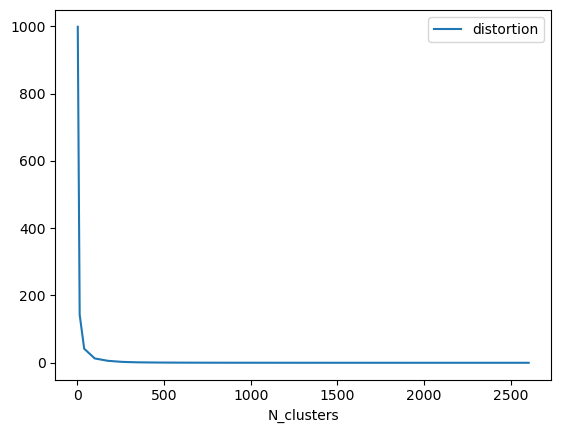

In [114]:
table.plot(x='N_clusters', y='distortion')

Como vemos, después de `N=200` (número de clústers) no hay gran variación de la distorsión, por tanto, no necesitamos variar de 0 a 1 el umbral de similitud (`cutoff`).  Vamos a cambiar la línea 7 para que solo llegue a 0.5 en lugar de 1.

In [115]:
# Inicializa una lista vacía llamada 'result' para almacenar los resultados del análisis de clustering.
result = list()

# Asigna la columna de fingerprints de Morgan del DataFrame molecule_dataset a la variable list_fingerprints.
# A diferencia del fragmento anterior, este utiliza el DataFrame completo, no solo las primeras 10 filas.
list_fingerprints = molecule_dataset['morgan_fp']

# Calcula la matriz de similitud de Tanimoto entre los fingerprints en 'list_fingerprints'.
# El resultado es una matriz cuadrada donde cada elemento (i, j) representa la similitud entre el fingerprint i y el fingerprint j.
similarity_matrix = tanimoto_matrix(list_fingerprints)  # Matriz de similitud

# Genera los índices de las posiciones que están por debajo de la diagonal principal de una matriz cuadrada.
# 'a' contiene los índices de las filas, y 'b' contiene los índices de las columnas.
# El argumento '-1' asegura que la diagonal principal no se incluya.
a, b = np.tril_indices(len(list_fingerprints), -1)  # índices de los elementos debajo de la diagonal principal

# Calcula la matriz de distancias a partir de la matriz de similitud.
# La distancia se calcula como 1 - similitud. Esto convierte las similitudes en distancias,
# donde una similitud de 1 (máxima similitud) corresponde a una distancia de 0, y una similitud de 0
# (mínima similitud) corresponde a una distancia de 1. Luego, se seleccionan solo las distancias
# correspondientes a la parte triangular inferior de la matriz (excluyendo la diagonal) usando los índices 'a' y 'b'.
dist_similarity_matrix = 1 - similarity_matrix[a, b] # distancias de los compuestos

# Itera sobre un rango de valores de umbral (cutoff) de 0 a 0.5 con un incremento de 0.05.
for i in np.arange(0, 0.5, 0.05):
    # Redondea el valor del umbral a 2 decimales.
    cutoff = round(i, 2)

    # Realiza el clustering de Butina utilizando la matriz de distancias y el umbral actual.
    # 'dist_similarity_matrix' contiene las distancias entre los compuestos.
    # 'len(list_fingerprints)' es el número total de compuestos.
    # 'distThresh' es el umbral de distancia para formar los clusters; los puntos dentro de este umbral se agrupan.
    # 'isDistData=True' indica que los datos de entrada son distancias, no similitudes.
    clusters = Butina.ClusterData(dist_similarity_matrix, len(list_fingerprints), distThresh=cutoff, isDistData=True)

    # Calcula el número de clusters ('n') y la distorsión ('dist') para el clustering actual.
    # La distorsión es una medida de cuán bien los clusters representan los datos.  Aquí, se utiliza el dataset completo.
    n, dist = distorion_tanimoto(clusters, molecule_dataset)

    # Agrega los resultados (cutoff, número de clusters, distorsión) a la lista 'result'.
    result.append((cutoff, n, dist))

# Crea un DataFrame de Pandas llamado 'table' a partir de la lista 'result'.
# Las columnas del DataFrame son 'cutoff', 'N_clusters' y 'distortion'.
table = pd.DataFrame(result, columns=['cutoff', 'N_clusters', 'distortion'])

# Imprime el DataFrame 'table'.
# Este DataFrame contiene los resultados del análisis de clustering para diferentes valores de umbral.
print(table)


   cutoff  N_clusters  distortion
0    0.00        2604    0.000000
1    0.05        2565    0.000014
2    0.10        2492    0.000238
3    0.15        2302    0.001822
4    0.20        1899    0.010048
5    0.25        1502    0.031032
6    0.30        1176    0.071083
7    0.35         919    0.141486
8    0.40         741    0.240713
9    0.45         607    0.394717


<Axes: xlabel='N_clusters'>

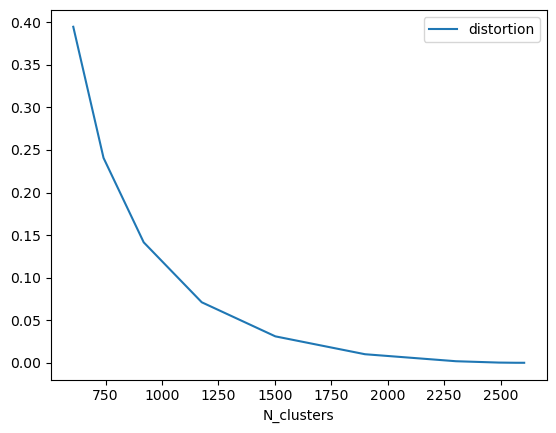

In [116]:
table.plot(x='N_clusters', y='distortion')

En la gráfica pordemos apreciar que al rededor de `N = 1500` hay un cambio brusco en la distorsión. La Tabla nos permite ver que para `N=1502` el `cutoff=0.25`. Veamos como queda el clústering con este valor:

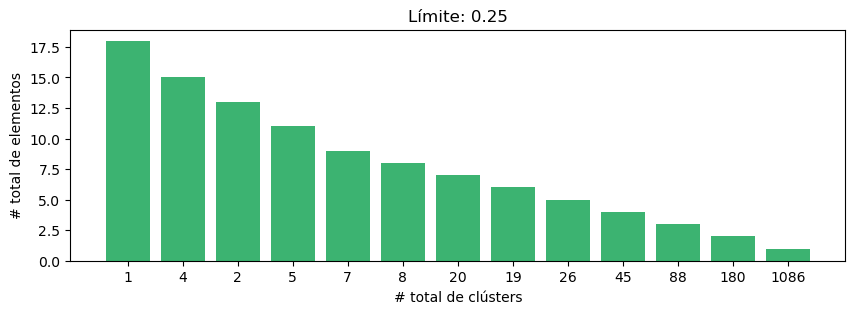

In [117]:
# Realiza el clustering de los fingerprints de Morgan ('morgan_fp_list') utilizando la función 'cluster_fingerprints'.
# El umbral de distancia para formar los clusters se establece en 0.25.
clusters = cluster_fingerprints(morgan_fp_list, cutoff=0.25)

# Configura la figura y los ejes para un gráfico de barras utilizando matplotlib.
# 'figsize' especifica el tamaño de la figura en pulgadas (ancho x alto).
fig, ax = plt.subplots(figsize=(10, 3)) # Configurar la figura de matplotlib

# Calcula el tamaño de cada cluster y lo almacena en una lista llamada 'agrup'.
# 'map(len, clusters)' aplica la función 'len' (longitud) a cada cluster en la lista 'clusters',
# obteniendo el número de elementos en cada cluster.
agrup = list(map(len, clusters))

# Calcula la frecuencia de cada tamaño de cluster.
# 'np.unique(agrup, return_counts=True)' devuelve dos arrays:
#  - 'unique': los tamaños de cluster únicos.
#  - 'counts': el número de veces que aparece cada tamaño de cluster.
unique, counts = np.unique(agrup, return_counts=True)

# Crea una tabla de frecuencia a partir de los tamaños de cluster únicos y sus recuentos.
# 'np.array([unique, counts]).T' crea un array 2D donde cada fila representa un tamaño de cluster y su frecuencia.
# 'np.flip(...)' invierte el orden de las filas, lo cual no is necessary for the code to run.
frec_table = np.flip(np.array([unique, counts]).T) # reversed order

# Crea un gráfico de barras.
# 'list(map(str, frec_table[:, 0]))' convierte los tamaños de cluster (primera columna de 'frec_table') a cadenas para usarlos como etiquetas en el eje x.
# 'frec_table[:, 1]' proporciona las frecuencias (segunda columna de 'frec_table') para el eje y (alturas de las barras).
# 'color="mediumseagreen"' establece el color de las barras en verde medio.
ax.bar(list(map(str, frec_table[:, 0])), frec_table[:, 1], color="mediumseagreen")

# Establece el título del gráfico.
ax.set_title(f"Límite: 0.25")

# Establece la etiqueta del eje x del gráfico.
ax.set_xlabel("# total de clústers") # corrected the typo in the original

# Establece la etiqueta del eje y del gráfico.
ax.set_ylabel("# total de elementos") # corrected the typo in the original

# Muestra el gráfico en pantalla.
plt.show()

# Cierra la figura para liberar memoria.
plt.close()


El clúster con más moléculas similares tiene 18 moléculas

In [118]:
# Convierte el primer cluster (índice 0) de la lista 'clusters' a una lista de índices.
# Esto asume que 'clusters' es una lista de listas, donde cada sublista contiene los índices
# de las moléculas que pertenecen a ese cluster.  El primer cluster se considera el más grande.
list_ind_cluster0 = list(clusters[0])

# Utiliza los índices del primer clúster para seleccionar las filas correspondientes del DataFrame 'molecule_dataset'.
# 'molecule_dataset.iloc[list_ind_cluster0]' selecciona las filas del DataFrame
# cuyos índices coinciden con los índices de las moléculas en el primer clúster.
# El resultado es un nuevo DataFrame llamado 'molecules_cluster0' que contiene solo las moléculas del primer clúster.
molecules_cluster0 = molecule_dataset.iloc[list_ind_cluster0]

# Imprime el DataFrame 'molecules_cluster0'.
# Esto muestra todas las columnas y filas del DataFrame, permitiendo inspeccionar las propiedades
# de las moléculas que pertenecen al cluster más grande.
molecules_cluster0


,molecule_chembl_id,smiles,ROMol,morgan_fp
1727,CHEMBL3735497,COCCN1CCC(CNC(=O)c2n[nH]c3ccc(OC)cc23)CC1,<rdkit.Chem.rdchem.Mol object at 0x178ba9e40>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
586,CHEMBL3735522,COCCN1CCC(CNC(=O)c2n[nH]c3ccc(-c4cncc(OC)c4)cc...,<rdkit.Chem.rdchem.Mol object at 0x178b8a350>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
1236,CHEMBL3736164,COCCN1CCC(CNC(=O)c2n[nH]c3ccc(-c4ccccc4)cc23)CC1,<rdkit.Chem.rdchem.Mol object at 0x178b9c430>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
1279,CHEMBL3734956,COc1ccc2[nH]nc(C(=O)NCC3CCN(CCCC(=O)O)CC3)c2c1,<rdkit.Chem.rdchem.Mol object at 0x178b9d740>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1314,CHEMBL3735962,COc1ccc2[nH]nc(C(=O)NCC3CCN(Cc4ccccc4)CC3)c2c1,<rdkit.Chem.rdchem.Mol object at 0x178b9e6d0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1417,CHEMBL3736216,COc1ccc2[nH]nc(C(=O)NCC3CCN(CCc4ccc(O)cc4)CC3)...,<rdkit.Chem.rdchem.Mol object at 0x178ba14a0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1540,CHEMBL3735863,COc1ccc2[nH]nc(C(=O)NCC3CCN(CCc4ccncc4)CC3)c2c1,<rdkit.Chem.rdchem.Mol object at 0x178ba4b30>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1570,CHEMBL3736122,COCCN1CCC(CNC(=O)c2n[nH]c3ccc(-c4ccc(OC)cc4)cc...,<rdkit.Chem.rdchem.Mol object at 0x178ba5890>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
1576,CHEMBL3736196,COc1ccc(CCN2CCC(CNC(=O)c3n[nH]c4ccc(OC)cc34)CC...,<rdkit.Chem.rdchem.Mol object at 0x178ba5b30>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1643,CHEMBL3736404,COc1ccc2[nH]nc(C(=O)NCC3CCN(CC(=O)O)CC3)c2c1,<rdkit.Chem.rdchem.Mol object at 0x178ba7900>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


18 moleculas del clúster de mayor tamaño


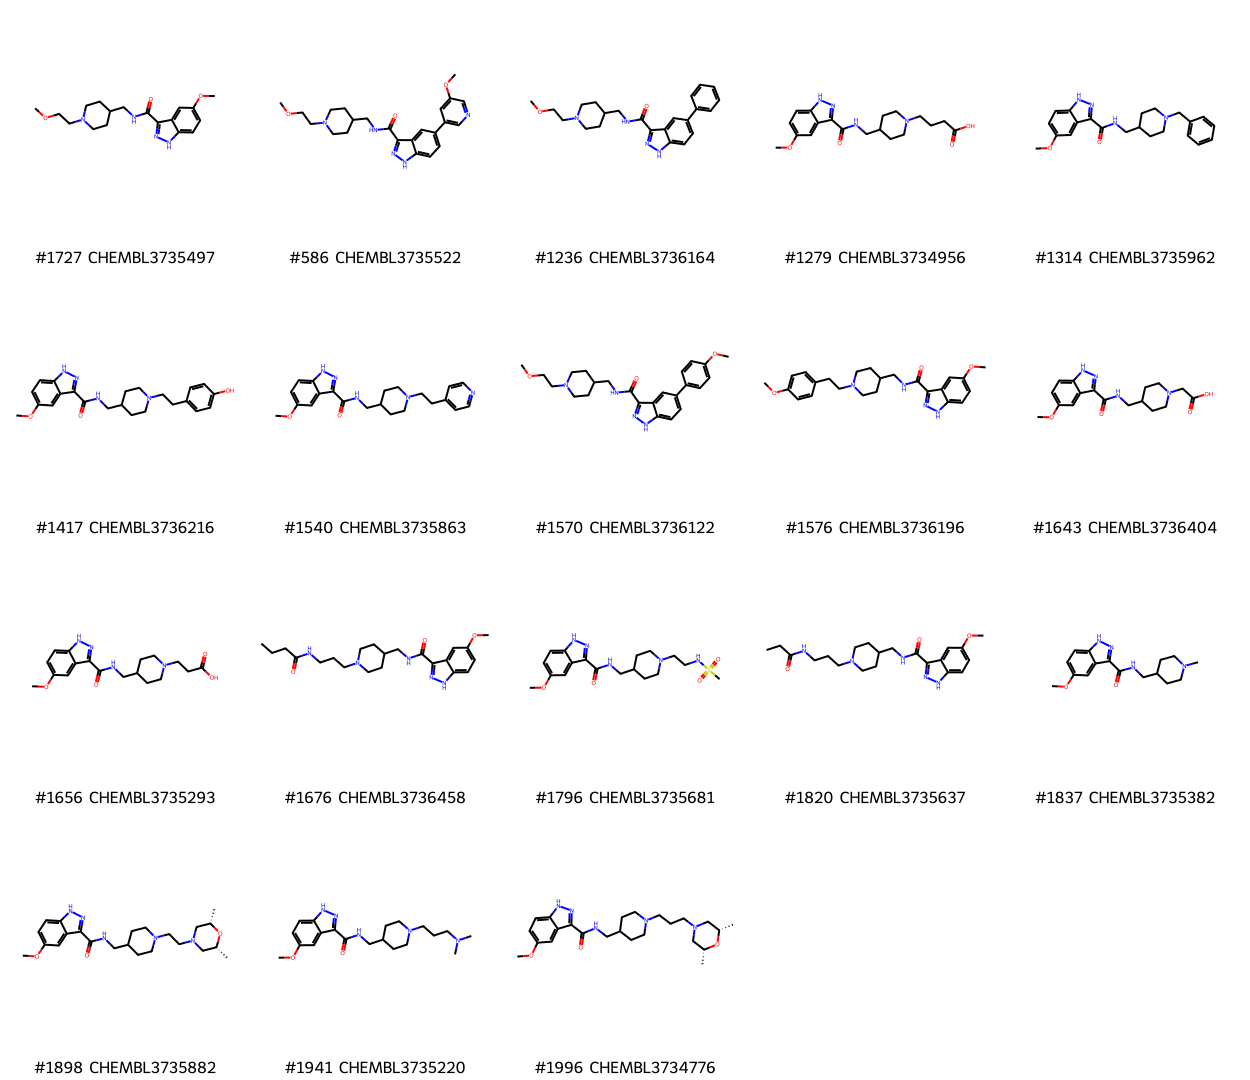

In [119]:
# Imprime el número de moléculas en el DataFrame 'molecules_cluster0', junto con un mensaje descriptivo.
print(f'{len(molecules_cluster0)} moleculas del clúster de mayor tamaño')

# Crea una lista de leyendas para las moléculas que se van a dibujar en la imagen de la cuadrícula.
# Itera sobre las filas del DataFrame 'molecules_cluster0'.
# Para cada molécula, formatea una cadena que incluye el índice de la fila y el valor de la columna 'molecule_chembl_id'.
legends = [
    f"#{index} {molecule['molecule_chembl_id']}"
    for index, molecule in molecules_cluster0.iterrows()
]

# Genera una imagen de cuadrícula que muestra las moléculas del primer clúster.
# 'mols' es una lista de objetos Mol de RDKit para dibujar, obtenida de la columna "ROMol" de 'molecules_cluster0'.
# 'legends' es la lista de cadenas creadas anteriormente, que se utilizan para etiquetar cada molécula en la cuadrícula.
# 'molsPerRow' especifica el número de moléculas por fila en la cuadrícula.
# 'subImgSize' especifica el tamaño de cada subimagen (molécula) en la cuadrícula.
Chem.Draw.MolsToGridImage(
    mols= molecules_cluster0["ROMol"].tolist(),
    legends=legends,
    molsPerRow=5,
    subImgSize=(250, 270),
)


## Clustermap
También podemos organizar la matriz de similitud de Tanimoto en un mapa de calor del agrupamiento jerárquico donde podemos ver cómo se agrupan las moléculas que mayor simlitud presentan

/Users/jessicavalero/anaconda3/envs/chemo/lib/python3.8/site-packages/fastcluster.py:26: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  from numpy import double, empty, array, ndarray, var, cov, dot, bool, \
/Users/jessicavalero/anaconda3/envs/chemo/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/jessicavalero/anaconda3/envs/chemo/lib/python3.8/site-packages/fastcluster.py:26: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  from numpy import double, empty, array, ndarray, var, cov, dot, bool, \
/Users/jessicavalero/anaconda3/envs/chemo/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


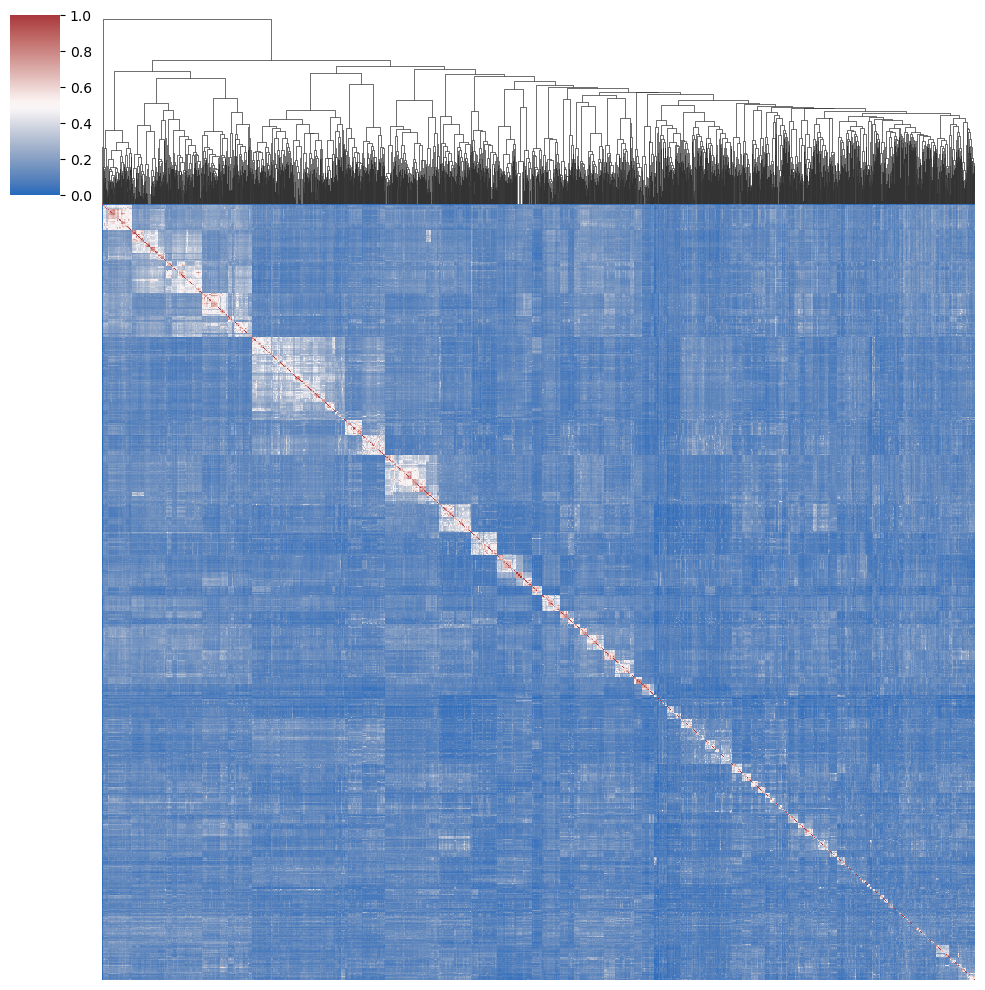

In [120]:
# Importa la función 'figure' del módulo 'matplotlib.pyplot', aunque no se usa directamente en este código.
from matplotlib.pyplot import figure

# Calcula la matriz de similitud de Tanimoto para la lista completa de fingerprints circulares ('circular_fp_list').
# Esto genera una matriz cuadrada donde cada elemento (i, j) representa la similitud de Tanimoto entre el fingerprint i y el fingerprint j.
similarity_matrix_full = tanimoto_matrix(circular_fp_list)

# Crea un mapa de calor agrupado (clustermap) de la matriz de similitud de Tanimoto utilizando la biblioteca Seaborn.
# 'similarity_matrix_full' es la matriz de entrada que se va a visualizar.
# 'cmap="vlag"' especifica la paleta de colores a utilizar (útil para visualizar similitudes, donde los colores extremos representan alta y baja similitud).
# 'dendrogram_ratio=(.1,.2)' ajusta la proporción de espacio dedicado a los dendrogramas de filas y columnas, respectivamente.
# 'yticklabels=False' y 'xticklabels=False' ocultan las etiquetas de los ejes y, lo que simplifica la visualización cuando el número de puntos es grande.
# 'figsize=(10,10)' establece el tamaño de la figura en pulgadas (ancho x alto).
g = sns.clustermap(similarity_matrix_full, cmap="vlag",
                   dendrogram_ratio=(.1,.2),
                   yticklabels=False,xticklabels=False,
                   figsize=(10,10))

# Elimina el dendrograma de las filas del mapa de calor agrupado.
# Esto puede ser útil para simplificar la visualización si solo se necesita el dendrograma de las columnas.
g.ax_row_dendrogram.remove()

# Crea un directorio llamado 'data/' si no existe.
# 'mkdir -p data/' es un comando de shell que crea el directorio 'data/' y sus directorios padres si es necesario.
# El signo '-p' evita que se genere un error si el directorio ya existe.  El '!' ejecuta el command shell.
!mkdir -p data/

# Guarda el mapa de calor agrupado en un archivo PNG.
# './data/TanimotoSimilarity.png' especifica la ruta y el nombre del archivo.
# 'bbox_inches='tight'' ajusta los límites de la figura para que todo el gráfico se ajuste en la imagen guardada.
# 'dpi=500' sets the resolution of the image
plt.savefig('./data/TanimotoSimilarity.png', bbox_inches='tight', dpi=500)

# Muestra el mapa de calor agrupado en pantalla.
plt.show()

# Cierra la figura para liberar memoria.
plt.close()


# Actividad práctica

Teniendo en cuenta lo revisado en esta segunda parte, realice un código en python con el cual pueda:

1. Seleccionar el clúster número 20 realizado con el algoritmo de agrupamiento Butina y un cutoff de 0.25 en esta práctica.
2. Calcular la matriz de similitud de Tanimoto, encontrar las distancias entre los compuestos que integran este clúster y hallar la distorsión para diferentes números de clústers utilizando el algoritmo de agrupamiento Butina.
3. Selecionar el umbral de similitud más adecuado según el método del codo.


Al finalizar deberá preparar un documento en formato PDF en el cual adjunte el input y como resultado de ejecución:
1. Tabla con cutoff, N_clusters y distortion.
2. Gráfico de lineas N_clusters vs Distortion.
3. Gráfico de barras para el # total de clústers y # total de elementos según el cutoff seleccionado.


# Conclusión

En esta práctica, hemos aprendido cómo usar huellas dactilares y medidas de similitud para comparar una molécula de consulta con un conjunto de datos de moléculas y clasificar la molécula por similitud. Además, aprendimos sobre la agrupación en clústeres de un conjunto de datos compuesto y discutimos cómo elegir un umbral de agrupación razonable.

# Referencias

1.  Seo, M., Shin, H. K., Myung, Y., Hwang, S., & No, K. T. (2020). Development of natural compound molecular fingerprint (Nc-mfp) with the dictionary of natural products (Dnp) for natural product-based drug development. Journal of Cheminformatics, 12(1), 6. https://doi.org/10.1186/s13321-020-0410-3
2. Capecchi, A., Probst, D., & Reymond, J.-L. (2020). One molecular fingerprint to rule them all: Drugs, biomolecules, and the metabolome. Journal of Cheminformatics, 12(1), 43. https://doi.org/10.1186/s13321-020-00445-4
3. Rácz, A., Bajusz, D., & Héberger, K. (2018). Life beyond the Tanimoto coefficient: Similarity measures for interaction fingerprints. Journal of Cheminformatics, 10(1), 48. https://doi.org/10.1186/s13321-018-0302-y
4. Nielsen, F. (2016). Hierarchical clustering. En F. Nielsen (Ed.), Introduction to HPC with MPI for Data Science (pp. 195-211). Springer International Publishing. https://doi.org/10.1007/978-3-319-21903-5_8
5. Butina, D. (1999). Unsupervised data base clustering based on daylight’s fingerprint and tanimoto similarity: A fast and automated way to cluster small and large data sets. Journal of Chemical Information and Computer Sciences, 39(4), 747-750. https://doi.org/10.1021/ci9803381
6. Shi, C., Wei, B., Wei, S., Wang, W., Liu, H., & Liu, J. (2021). A quantitative discriminant method of elbow point for the optimal number of clusters in clustering algorithm. EURASIP Journal on Wireless Communications and Networking, 2021(1), 31. https://doi.org/10.1186/s13638-021-01910-w